# Fáza 3 - Strojové učenie (v 12. týždni): 20 bodov

__Autori:__ Dávid Penťa, Samuel Bernát
__Percentuálny podiel práce:__ 50% / 50%

Pri dátovej analýze nemusí byť naším cieľom získať len znalosti obsiahnuté v aktuálnych dátach, ale aj natrénovať model, ktorý bude schopný robiť rozumné predikcie pre nové pozorovania pomocou techniky strojového učenia.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from IPython.display import HTML
from sklearn.svm import SVR
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

## Prvotné načítanie údajov

In [8]:
X_train = pd.read_csv('transformed_data/X_train.csv')
y_train = pd.read_csv('transformed_data/y_train.csv')
X_test = pd.read_csv('transformed_data/X_test.csv')
y_test = pd.read_csv('transformed_data/y_test.csv')
features = X_train.columns.values.tolist()
var_name = y_train.columns.values[0]

## Jenoduchý klasifikátor na základe závislostí v dátach
V tomto kroku implementujeme vlastný OneR algoritmus, ktorý slúži ako jednoduchý klasifikátor pre náš dataset, aby sme zistili atribút s najmenšou odchylkou. Aplikujeme ho na testovaciu a zároveň trénovaciu množinu.

In [9]:
def oneRule_get_y(X, feature, split,  side1):

    y = pd.DataFrame(-1, index=range(X.shape[0]), columns=[var_name])

    if side1 == 1:
        side2 = 0
    else:
        side2 = 1

    y.loc[X[feature] < split, var_name] = side1
    y.loc[X[feature] >= split, var_name] = side2

    return y

In [10]:
def oneRule(X, y, feature, split, side1):
    pred_y = oneRule_get_y(X, feature, split,  side1)
    accuracy = accuracy_score(y[var_name], pred_y[var_name])
    precision = precision_score(y[var_name], pred_y[var_name])
    recall = recall_score(y[var_name], pred_y[var_name])

    return (accuracy + precision + recall) / 3


In [11]:
def oneRule_predict(X_, y_):
    oneR_X = X_.copy()
    oneR_y = y_.copy()

    best_side = 0
    best_split = 0
    best_feature = 0
    best_total = 0


    for feature in features:
        if feature != var_name:
            split = (oneR_X[feature][oneR_y[var_name] == 0].mean() + oneR_X[feature][oneR_y[var_name] == 1].mean()) / 2

            if oneR_X[feature][0] < split:
                if oneR_y[var_name][0] == 1:
                    side = 1
                else:
                    side = 0
            else:
                if oneR_y[var_name][0] == 1:
                    side = 0
                else:
                    side = 1

            total = oneRule(oneR_X, oneR_y, feature, split, side)
            if total > best_total:
                best_split = split
                best_feature = feature
                best_total = total
                best_side = side


    return [oneRule_get_y(oneR_X, best_feature, best_split, best_side), [best_feature, best_split, best_side]]

Po aplikovaní OneR algoritmu na stĺpce našich datasetov vo výsledku vidíme, že atribútom s najlepšími vlastnosťami je PAHs (Polycyclis Aromatic Hydrocarbons). Vyhodnocovacími mertrikami sú accuracy, precision a recall. Takisto, pre oba trénovacie datasety môžeme pozorovať mierne odchýlky vo výsledných hodnotách. Odchýlky su zaznamenané v riadku Diff.

In [12]:
y_train_pred, oneR_model = oneRule_predict(X_train, y_train)
y_test_pred = oneRule_get_y(X_test, oneR_model[0], oneR_model[1], oneR_model[2])

train_accuracy = accuracy_score(y_train[var_name], y_train_pred[var_name])
train_precision = precision_score(y_train[var_name], y_train_pred[var_name])
train_recall = recall_score(y_train[var_name], y_train_pred[var_name])
train_total = (train_accuracy + train_precision + train_recall) / 3

test_accuracy = accuracy_score(y_test[var_name], y_test_pred[var_name])
test_precision = precision_score(y_test[var_name], y_test_pred[var_name])
test_recall = recall_score(y_test[var_name], y_test_pred[var_name])
test_total = (test_accuracy + test_precision + test_recall) / 3

print('Best feature: ' + oneR_model[0])
print('        accuracy   precision  recall     total')
print("Train   {:.8f} {:.8f} {:.8f} {:.8f}".format(*[train_accuracy, train_precision, train_recall, train_total]))
print("Test    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[test_accuracy, test_precision, test_recall, test_total]))
print("Diff    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[abs(test_accuracy-train_accuracy), abs(test_precision-train_precision), abs(test_recall-train_recall), abs(test_total-train_total)]))

Best feature: PAHs
        accuracy   precision  recall     total
Train   0.82981176 0.88714587 0.81729940 0.84475234
Test    0.83321454 0.89318281 0.81854357 0.84831364
Diff    0.00340278 0.00603694 0.00124418 0.00356130


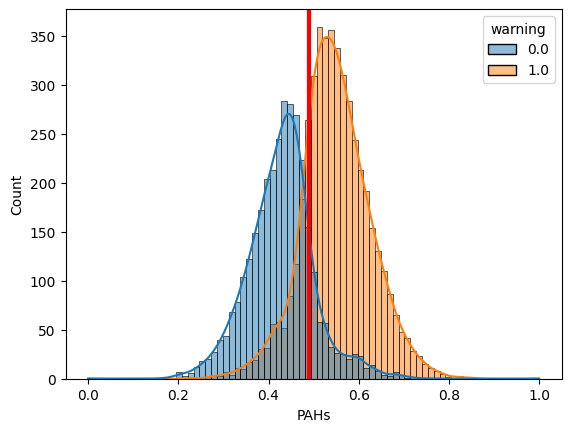

In [13]:
sns.histplot(data=X_train, hue=y_train[var_name] , x=oneR_model[0], fill=True, kde=True)
plt.axvline(oneR_model[1], linewidth=3, color='r')
plt.show()

V grafickej reprezentácii výsledkov algoritmu atribútu PAHs môžeme pozorovať vyrátané hodnoty v diagrame. Na základe výsledkov konštatujeme, že síce sa jedná o pomerne jednoduchú metódu, výsledky sú slabé. Preto budeme v ďalších krokoch testovať ďalšie metódy vyhodnocovania klasifikátorom.

## Trénovanie a vyhodnotenie klasifikátorov strojového učenia (5b)
- Na trénovanie využite minimálne jeden stromový algoritmus strojového učenia v scikit-learn.
- Vizualizujte natrénované pravidlá.
- Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall
- Porovnajte aspoň jeden natrénovaný klasifikátor v scikit-learn s jednoduchým klasifikátorom
z prvého kroku.


In [14]:
from sklearn.metrics import confusion_matrix, classification_report


def print_accuracy_precision_recall_total(model, X_train_, X_test_, y_train_, y_test_):
    y_train_pred_arr = model.predict(X_train_)
    y_test_pred_arr = model.predict(X_test_)

    y_train_pred = pd.DataFrame({var_name: y_train_pred_arr.ravel()})
    y_test_pred = pd.DataFrame({var_name: y_test_pred_arr.ravel()})

    train_accuracy = accuracy_score(y_train_[var_name], y_train_pred[var_name])
    train_precision = precision_score(y_train_[var_name], y_train_pred[var_name])
    train_recall = recall_score(y_train_[var_name], y_train_pred[var_name])
    train_total = (train_accuracy + train_precision + train_recall) / 3

    test_accuracy = accuracy_score(y_test_[var_name], y_test_pred[var_name])
    test_precision = precision_score(y_test_[var_name], y_test_pred[var_name])
    test_recall = recall_score(y_test_[var_name], y_test_pred[var_name])
    test_total = (test_accuracy + test_precision + test_recall) / 3

    print('        accuracy   precision  recall     total')
    print("Train   {:.8f} {:.8f} {:.8f} {:.8f}".format(*[train_accuracy, train_precision, train_recall, train_total]))
    print("Test    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[test_accuracy, test_precision, test_recall, test_total]))
    print("Diff    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[abs(test_accuracy-train_accuracy), abs(test_precision-train_precision), abs(test_recall-train_recall), abs(test_total-train_total)]))

    print('Train')
    fig, ax = plt.subplots(figsize=(2,2))
    mat = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, ax=ax)
    plt.xlabel('real')
    plt.ylabel('predicted')
    plt.show()
    print(classification_report(y_train, y_train_pred, target_names = ["0","1"]))

    print('Test')
    fig, ax = plt.subplots(figsize=(2,2))
    mat = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, ax=ax)
    plt.xlabel('real')
    plt.ylabel('predicted')
    plt.show()

    print(classification_report(y_test, y_test_pred, target_names = ["0","1"]))

### Decision tree classifier
V tomto kroku aplikujeme na trénovaciu množinu klasifikátor Decision Tree Classifier. Po predchádzajúcich slabých výsledkoch za použitia OneR algoritmu dúfame, že výsledky za použitia tohto klasifikátora budú o niečo lepšie.

In [29]:
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

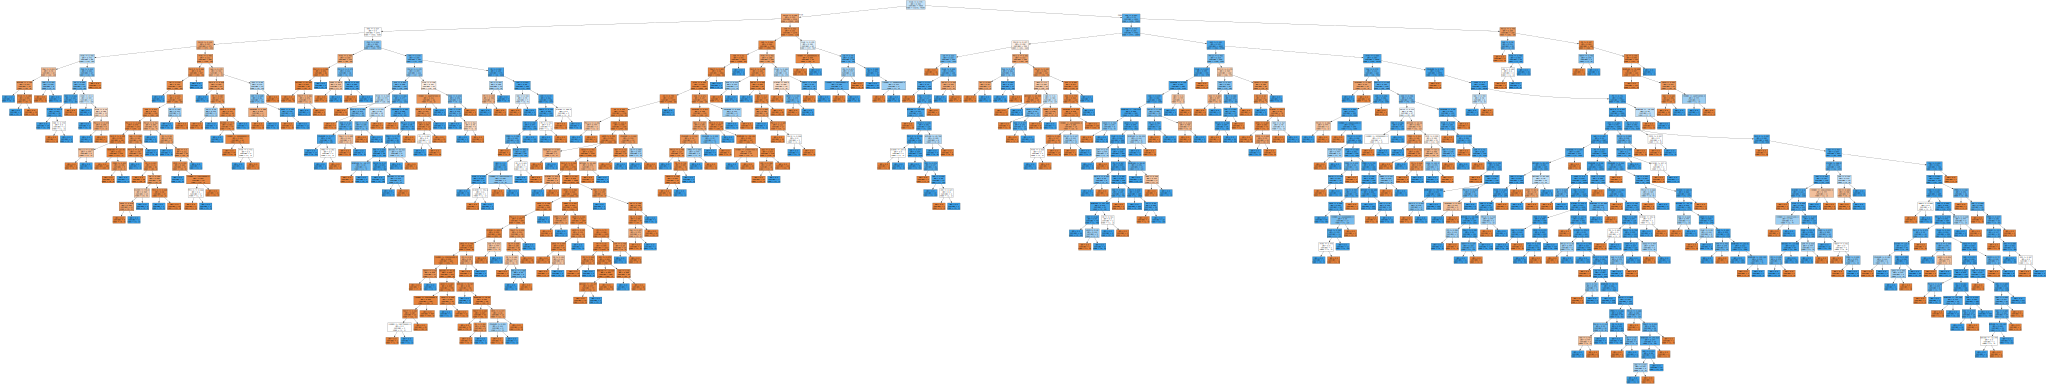

In [16]:
from IPython.core.display_functions import display

graph = Source(export_graphviz(dt,
                               out_file=None,
                               feature_names=features,
                               filled = True))

display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:100% !important;height:100% !important;}</style>"
HTML(style)

        accuracy   precision  recall     total
Train   1.00000000 1.00000000 1.00000000 1.00000000
Test    0.90591589 0.92221779 0.92001592 0.91604987
Diff    0.09408411 0.07778221 0.07998408 0.08395013
Train


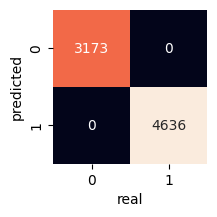

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3173
           1       1.00      1.00      1.00      4636

    accuracy                           1.00      7809
   macro avg       1.00      1.00      1.00      7809
weighted avg       1.00      1.00      1.00      7809

Test


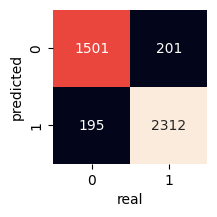

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1696
           1       0.92      0.92      0.92      2513

    accuracy                           0.91      4209
   macro avg       0.90      0.90      0.90      4209
weighted avg       0.91      0.91      0.91      4209



In [31]:
print_accuracy_precision_recall_total(dt, X_train, X_test, y_train, y_test)

Napriek očakávaniu lepších výsledkov Decision Tree Classifiera z tabuľky výsledkov vyššie vidíme, že tomu tak nie je. V tejto metóde došlo vo veľmi vysokej miere k overfittingu dát.

mega overfitting

### Random Forest Classifier
Okrem Decision Tree Classifier sme sa rozhodli otestovať Random Forest Classifier na testovacej a trénovacej množine. Vo výsledkoch nižie vidíme, že aj za použitia tejto metódy dochádza v určitej miere k overfittingu, avšak nižšej ako pri predchádzajúcej metóde. Takisto môžeme pozorovať, že výsledky v porovnaní testovacieho a trénovacieho datasetu sa líšia výrazne menej ako predtým.


In [4]:
rf = RandomForestClassifier()
rf = rf.fit(X_train.copy(), np.ravel(y_train))
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

NameError: name 'RandomForestClassifier' is not defined

        accuracy   precision  recall     total
Train   1.00000000 1.00000000 1.00000000 1.00000000
Test    0.95010691 0.94962905 0.96776761 0.95583452
Diff    0.04989309 0.05037095 0.03223239 0.04416548
Train


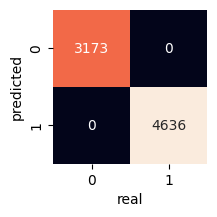

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3173
           1       1.00      1.00      1.00      4636

    accuracy                           1.00      7809
   macro avg       1.00      1.00      1.00      7809
weighted avg       1.00      1.00      1.00      7809

Test


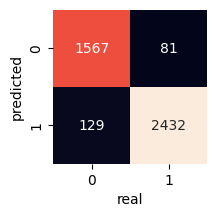

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1696
           1       0.95      0.97      0.96      2513

    accuracy                           0.95      4209
   macro avg       0.95      0.95      0.95      4209
weighted avg       0.95      0.95      0.95      4209



In [13]:
print_accuracy_precision_recall_total(rf, X_train, X_test, y_train, y_test)

tiez ma overfit

## Optimalizácia alias hyperparameter tuning (5b)
- Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok.
- Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

V tomto kroku sme sa pokúsili nájsť čo najlepšie hyperparametre, aby sme minimalizovali overfitting a čo najviac optimalizovali výsledky. Keďže v minulých krokoch bol overfitting pomerne výrazný, preto sme sa snažili určiť parametre, ktorých zmenou a správnym nastavením kombinácii vieme čo najlepšie optimalizovať úspešnosť klasifikátora. Využívali sme pri tom metódu Grid Search, ktorá nám vytvorila kombinácie zadaných parametrov.

<br>

#### Hyperparametre:
- max_depth = maximálna hĺbka stromu
- min_sample_split = minimálny počet vzoriek na danom uzle potrebný na to, aby uzol vedeli rozdeliť (čísla 2, 5, 10, 15 a 20)
- min_sample_leaf = minimálny počet vzoriek, ktorý musí byť na danom uzle (čísla 1, 2, 5 a 10)
- criterion = zmenenie typu kvality rozdeľovania (hodnoty gini, entroopy a log_loss)
- splitter = spôsob rozdelenia stromu na danom uzle (typy best a random)

In [17]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, np.ravel(y_train))
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
informative_features = X_train.columns[feature_idx]
informative_features

Index(['PM10', 'C2H3NO5', 'NH3', 'CH4', 'PAHs'], dtype='object')

In [18]:
X_train_info = X_train[informative_features].copy()
X_test_info = X_test[informative_features].copy()

### Decision Tree Classifier
Metóda Grid Search použitá pri Decision Tree Classifier za použitia 4 cross validácií pri 960 kandidátoch. Hĺbka stromu je 8.

In [ ]:
# grid search
max_depth = [5, 8, 10, 15, 20, 30, 40, 50]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10]
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]

dt = tree.DecisionTreeClassifier()

hyper = dict(max_depth = max_depth,
             splitter=splitter,
             min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf,
             criterion = criterion)

gs_dt = GridSearchCV(estimator=dt, param_grid=hyper, cv=4, verbose=1, n_jobs=-1)
gs_dt = gs_dt.fit(X_train_info, np.ravel(y_train))
print(gs_dt.best_params_)
print_accuracy_precision_recall_total(gs_dt.best_estimator_, X_train_info, X_test_info, y_train, y_test)

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 15, 'splitter': 'best'}
Fitting 4 folds for each of 960 candidates, totalling 3840 fits


KeyboardInterrupt: 

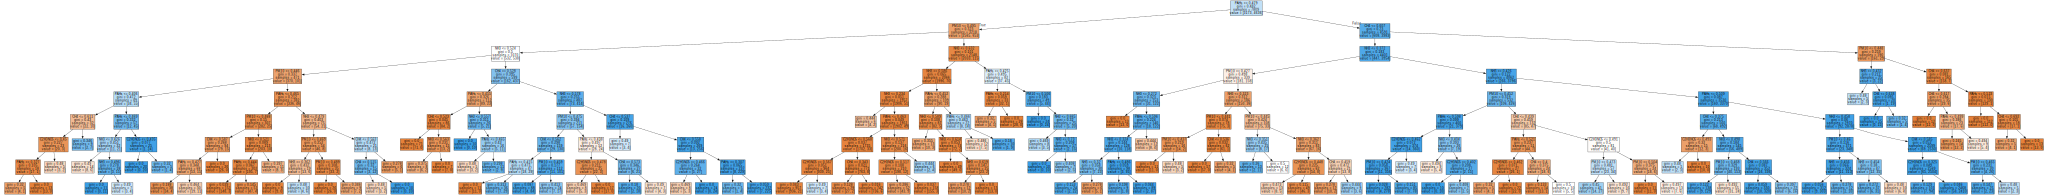

In [36]:
graph = Source(export_graphviz(gs_dt.best_estimator_,
                               out_file=None,
                               feature_names=informative_features,
                               filled = True))

display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:100% !important;height:100% !important;}</style>"
HTML(style)

In [37]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train_info, y_train)

In [43]:
# path pruning
tr = gs_dt.best_estimator_

path = tr.cost_complexity_pruning_path(X_train1, y_train1)

alphas = path.ccp_alphas
clfs = []

for alpha in alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=alpha)
    clf.fit(X_train1, y_train1)
    clfs.append(clf)

train_scores = [clf.score(X_train2, y_train2) for clf in clfs]
index_best_model = np.argmax(train_scores)

best_model = clfs[index_best_model]

        accuracy   precision  recall     total
Train   0.95133820 0.95161290 0.96721311 0.95672141
Test    0.92611072 0.93142633 0.94588142 0.93447282
Diff    0.02522748 0.02018657 0.02133170 0.02224858
Train


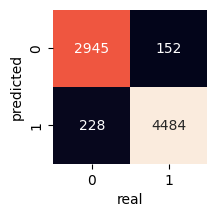

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3173
           1       0.95      0.97      0.96      4636

    accuracy                           0.95      7809
   macro avg       0.95      0.95      0.95      7809
weighted avg       0.95      0.95      0.95      7809

Test


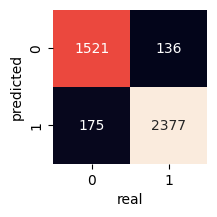

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1696
           1       0.93      0.95      0.94      2513

    accuracy                           0.93      4209
   macro avg       0.92      0.92      0.92      4209
weighted avg       0.93      0.93      0.93      4209



In [39]:
print_accuracy_precision_recall_total(best_model, X_train_info, X_test_info, y_train, y_test)

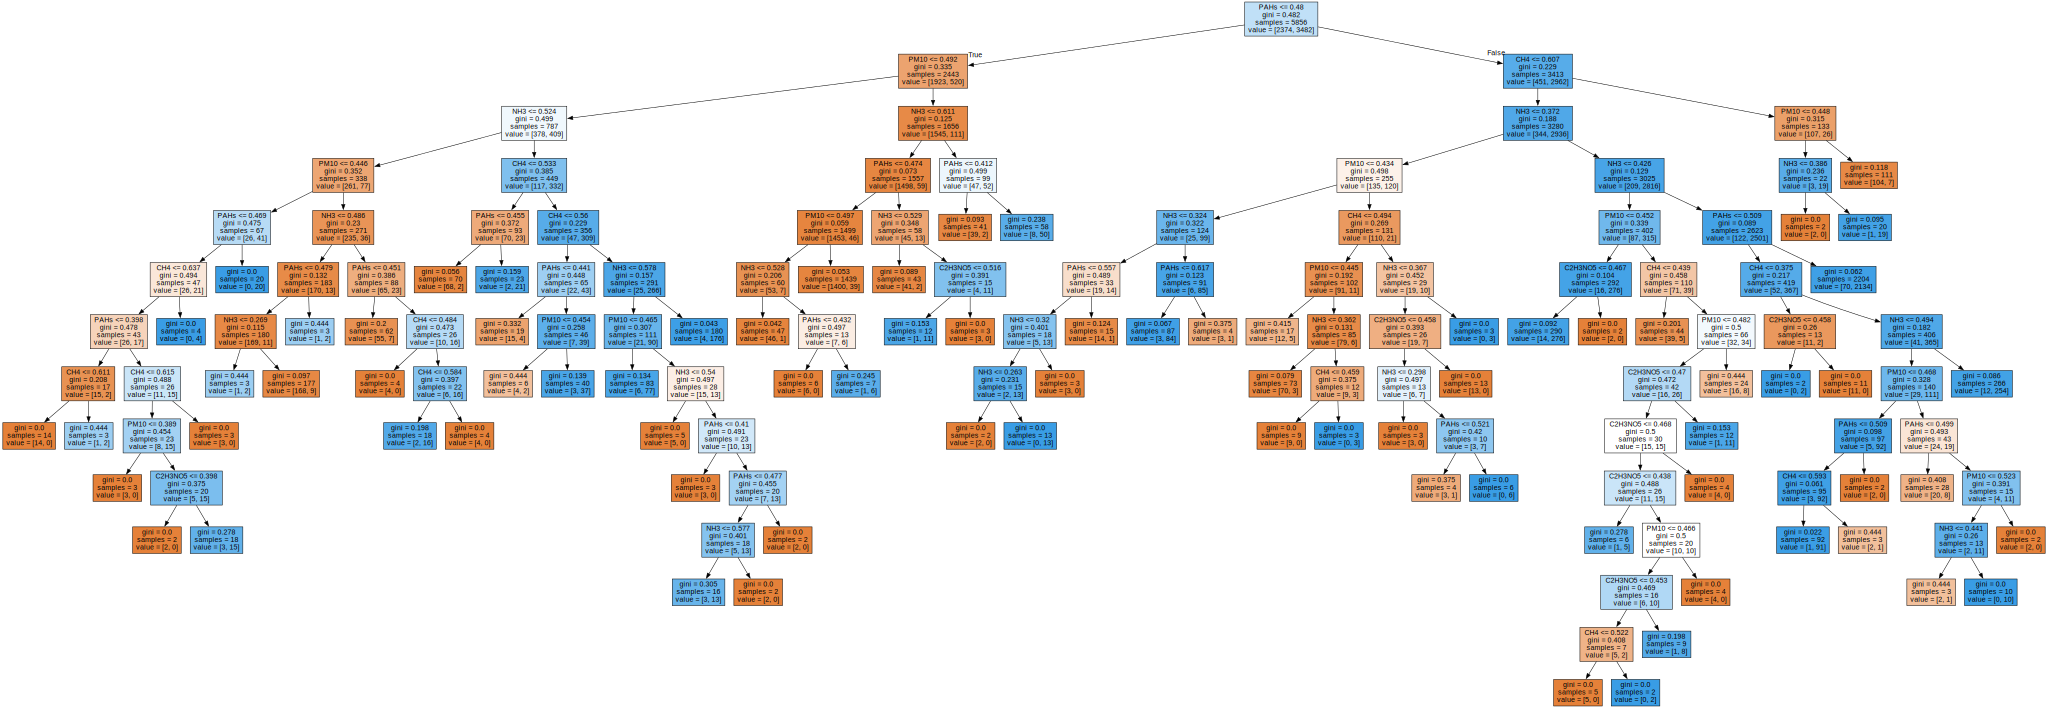

In [21]:
graph = Source(export_graphviz(best_model,
                               out_file=None,
                               feature_names=informative_features,
                               filled = True))

display(SVG(graph.pipe(format='svg')))

style = "<style>svg{width:100% !important;height:100% !important;}</style>"
HTML(style)

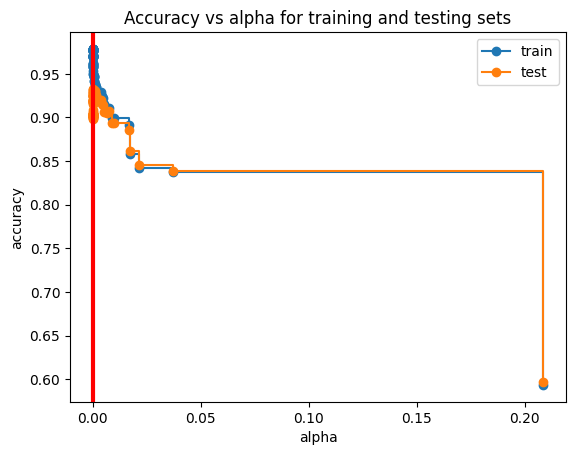

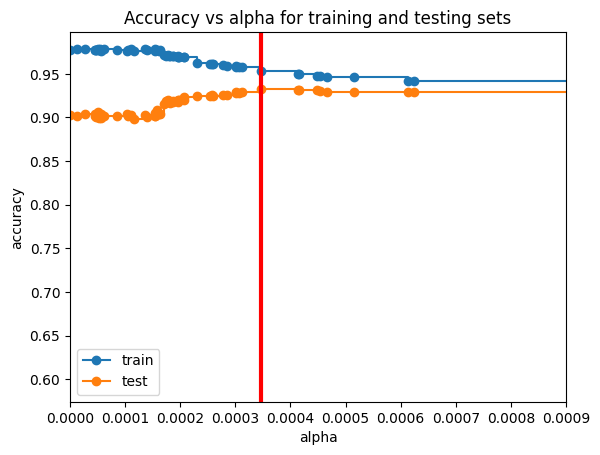

In [22]:
train_scores = [clf.score(X_train_info, y_train) for clf in clfs]
test_scores = [clf.score(X_test_info, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.axvline(alphas[index_best_model], linewidth=3, color='r')
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.axvline(alphas[index_best_model], linewidth=3, color='r')
plt.xlim(left=0)
plt.xlim(right=0.0009)
plt.show()

In [1]:
# random search
n_estimators = [100, 200, 300, 400, 500]
max_depth = [5, 10, 20, 30, 40, 50]
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 5, 10]

forest = RandomForestClassifier()
rf1 = forest.fit(X_train1, np.ravel(y_train1))

hyper = dict(n_estimators = n_estimators,
             max_depth = max_depth,
             min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf
            )

rs_rf = RandomizedSearchCV(estimator=rf1, param_distributions=hyper, cv=4, verbose=1, n_jobs=-1)
rs_rf = rs_rf.fit(X_train2, np.ravel(y_train2))

print(rs_rf.best_params_)
print_accuracy_precision_recall_total(rs_rf.best_estimator_, X_train_info, X_test_info, y_train, y_test)

NameError: name 'RandomForestClassifier' is not defined

## Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b)
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy:
- Stratégie riešenia chýbajúcich hodnôt a outlierov;
- Scaling resp. transformer či zlepší accuracy klasifikácie;
- Výber atribútov a výber algoritmov strojového učenia;
- Hyperparameter tuning resp. ensemble learning.
Ktoré spôsoby z hore-uvedených bodov sa ukázali ako učinné pre Váš dataset? Hodnotenie podložíte dôkazmi.

<br>

V tejto časti vyhodnotíme vplyv nami zvolených stratégií na klasifikáciu a popíšeme, ako sme pracovali a aké metódy sme pri práci využili.

### Stratégie riešenia chýbajúcich hodnôt a outlierov
Čo sa týka chýbajúcich hodnôt a outlierov, aby sme predišli predikácii hodnôt rozhodli sme sa chýbajúce a vychýlené hodnoty z datasetu odstrániť, pretože už v predošlých štádiách sa ukázalo, že počet takýchto hodnôt je len niečo okolo 5%, čo je prijateľná mierka na využitie tejto metódy. V porovnaní s ostatnými metódami, ako napríklad nahradenie hodnoty mediánom, pomocou kNN, či priemerom sa nám vymazanie sa týchto hodnôt zdalo ako najlepšie a zároveň najefektívnejšie riešenie vzhľadom k tomu, aby sme zachovali čo najväčšiu presnosť dát.

In [56]:
train_data = pd.read_csv("data/measurements.csv", sep='\t')
train_data.dropna(inplace=True)
train_data.head(15)

,PM10,CO,Pb,C2H3NO5,CFCs,H2CO,O3,TEMP,NOx,SO2,latitude,longitude,NH3,CH4,PRES,PM2.5,warning,PAHs
0,6.33846,6.61796,44.89247,0.22646,37.51693,39.50358,6.93304,18.26344,7.24953,8.60015,53.95278,32.86389,5.35805,6.00130,1136.95323,10.59506,1.0,9.24391
2,6.78253,7.32578,50.42226,0.27588,53.51533,61.03352,6.41183,13.61953,8.25103,8.93315,58.63667,59.80222,5.16975,5.07507,1148.76311,10.04912,1.0,8.73640
3,5.71508,9.26158,26.86094,0.18788,35.69230,57.17648,7.94233,16.76223,4.10062,4.44370,12.95629,78.27539,5.76106,7.01203,1089.36057,10.53430,1.0,8.67231
4,9.16375,7.12481,48.82457,1.32986,32.22006,46.82387,11.63958,12.48813,6.26932,7.81736,32.54044,-82.90375,5.96896,8.44913,1099.39295,9.40919,0.0,4.80834
5,7.04390,7.96828,56.56011,0.31311,56.18221,41.18541,10.42120,12.74538,8.75889,7.43447,37.73604,-120.93549,8.58263,6.89506,1050.67737,7.20484,0.0,6.00215
6,8.07997,6.40977,58.46766,0.67969,60.60543,34.99728,9.14442,22.17319,6.75870,8.48118,3.51667,11.50000,7.64965,8.33486,1107.84036,8.70999,0.0,6.88903
7,7.29130,7.98165,51.66434,0.32651,58.74764,34.19093,8.08972,2.44131,8.52918,7.19837,34.09668,-117.71978,9.57044,9.39463,1151.83879,6.68114,1.0,6.25543
8,8.35517,6.93280,19.34860,0.81349,55.69528,41.58524,9.23259,2.99513,7.51361,5.92541,10.20898,123.75800,5.64815,8.15221,1121.79391,8.18714,0.0,4.12422
9,8.13981,7.40637,61.53701,0.61849,47.76755,61.36477,10.36692,13.31374,7.97743,7.96606,4.02219,101.02083,9.85029,7.40917,1157.28796,8.65797,1.0,7.83400
10,10.08968,6.88791,37.89372,3.02777,36.54980,32.98070,10.37013,23.01118,9.14681,7.64110,22.75218,72.68533,8.80552,4.32548,1085.64050,10.18344,1.0,11.72607


### Scaling resp. transformer či zlepší accuracy klasifikácie
Vo svojich testovaniach sme na najlepší Classifier - Random Forest Clasifier aplikovali niekoľko typov scalingu. Išlo napríklad o Hyperparameter tuning a Cross validation, aby sme eliminovali overfitting classifierov. Po pozretí výsledkov testovaní môžeme tvrdiť, že tieto metódy mali vplyv na overfitting a značne optimalizovali výsledok.

### Výber atribútov a výber algoritmov strojového učenia
Na našich datasetoch sme testovali 3 algoritmy strojového učenia, a to OneR algoritmus, Decision Tree Classifier a Random Forest Classifier. Z výsledkov testovania vidíme, že OneR je síce pomerne jednoduchý, no za to nie veľmi efektívny. Decision Tree Classifier je síce lepší, ale stále dochádza k veľkému overfittingu. Najlepšie výsledky dava Random Forest Clasifier.

In [25]:
print('Best feature: ' + oneR_model[0])
print('        accuracy   precision  recall     total')
print("Train   {:.8f} {:.8f} {:.8f} {:.8f}".format(*[train_accuracy, train_precision, train_recall, train_total]))
print("Test    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[test_accuracy, test_precision, test_recall, test_total]))
print("Diff    {:.8f} {:.8f} {:.8f} {:.8f}".format(*[abs(test_accuracy-train_accuracy), abs(test_precision-train_precision), abs(test_recall-train_recall), abs(test_total-train_total)]))

Best feature: PAHs
        accuracy   precision  recall     total
Train   0.82981176 0.88714587 0.81729940 0.84475234
Test    0.83321454 0.89318281 0.81854357 0.84831364
Diff    0.00340278 0.00603694 0.00124418 0.00356130


        accuracy   precision  recall     total
Train   1.00000000 1.00000000 1.00000000 1.00000000
Test    0.90734141 0.92006332 0.92518902 0.91753125
Diff    0.09265859 0.07993668 0.07481098 0.08246875
Train


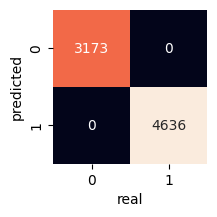

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3173
           1       1.00      1.00      1.00      4636

    accuracy                           1.00      7809
   macro avg       1.00      1.00      1.00      7809
weighted avg       1.00      1.00      1.00      7809

Test


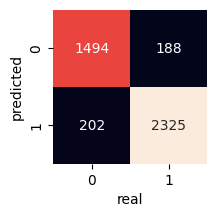

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1696
           1       0.92      0.93      0.92      2513

    accuracy                           0.91      4209
   macro avg       0.90      0.90      0.90      4209
weighted avg       0.91      0.91      0.91      4209



In [30]:
print_accuracy_precision_recall_total(best_model, X_train_info, X_test_info, y_train, y_test)
print_accuracy_precision_recall_total(dt, X_train, X_test, y_train, y_test)

In [ ]:
# # Recursive feature elimination (RFE)
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, n_features_to_select=5, step=1)
# selector = selector.fit(X_train, y_train)
#
# print(selector.support_)
# print(selector.ranking_)
#
# # Feature selection using SelectFromModel
# selector = SelectFromModel(estimator=LogisticRegression()).fit(X_train, y_train)
# print(selector.estimator_.coef_)
# print(selector.threshold_)
# print(selector.get_support())

C:\Users\Samko\Documents\GitHub\IAU\venv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Hyperparameter tuning resp. ensemble learning
Rozhodli sme sa použiť 2 optimalizačné spôsoby pre hľadanie hodnôt hyperparametrov za použitia Random Forrest Classifier a to Grid Search a Path Pruning. Grid Search sme robili pomocou určenia hyperparametrov max_depth, min_sample_split, min_sample_leaf, criterion a splitter. Nižšie vidíme, že najlepší klasifikátor je Decision Tree Classifier za použitia vypísaných hyperparametrov. Výsledky sú v porovnaní s inými parametrami omnoho presnejšie, pretože overfitting bol čo najviac eliminivaný.

In [22]:
gs_dt.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=15)

In [51]:
print(gs_dt.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 15, 'splitter': 'best'}
